# Book Recommendation System – Data Cleaning & EDA


## Imports and Setup
# This section imports all necessary libraries and sets up the environment


In [1]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For enhanced data visualization
import sys  # For system-specific parameters and functions
from matplotlib.pyplot import loglog, xscale  # For log-scale plotting
from scipy.sparse import csr_matrix  # For sparse matrix operations
from scipy.sparse import save_npz  # For sparse matrix operations
import json

from utils.preprocessing import *
from utils.data_loader import *

## Load Data
# Loading the three main datasets: books, users, and ratings


In [2]:
books_df = load_books()  # Load book metadata (title, author, etc.)
users_df = load_users()  # Load user demographic data
ratings_df = load_ratings()  # Load user-book rating data


## Initial Exploration – Shape and Data Types
# Basic exploration of dataset shapes and data types to understand data structure


In [3]:
print(books_df.shape)  # Print dimensions of books dataframe
print(users_df.shape)  # Print dimensions of users dataframe
print(ratings_df.shape)  # Print dimensions of ratings dataframe

print(books_df.dtypes, "\n #########################")  # Print data types of book columns
print(users_df.dtypes, "\n #########################")  # Print data types of user columns
print(ratings_df.dtypes, "\n ########################")  # Print data types of rating columns


(271360, 8)
(278858, 3)
(1149780, 3)
ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object 
 #########################
User-ID       int64
Location     object
Age         float64
dtype: object 
 #########################
User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object 
 ########################


## Check Unique Entries and Nulls
# Checking for unique identifiers and null values to assess data quality


In [4]:
print(books_df["ISBN"].nunique())  # Count unique book identifiers
print(users_df["User-ID"].nunique())  # Count unique user identifiers

print(books_df.isnull().sum(), "###################################")  # Count nulls in books
print(ratings_df.isnull().sum(), "###################################")  # Count nulls in ratings


271360
278858
ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64 ###################################
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64 ###################################


## Clean Ratings – Replace 0 with NaN and Drop
# Cleaning the ratings by replacing 0 values (invalid) with NaN and dropping them


In [5]:
ratings_df = clean_ratings(ratings_df)

## Sanity Check – Invalid Ratings
# Verifying there are no ratings outside the valid range (1-10)


In [6]:
print(ratings_df[ratings_df["Book-Rating"] < 0])  # Check for negative ratings
print(ratings_df[ratings_df["Book-Rating"] > 10])  # Check for ratings above 10


Empty DataFrame
Columns: [User-ID, ISBN, Book-Rating]
Index: []
Empty DataFrame
Columns: [User-ID, ISBN, Book-Rating]
Index: []


## Clean Book Table – Drop Nulls and Duplicates 
# Cleaning the books dataset by removing nulls and duplicate titles


In [7]:
books_df = clean_books(books_df)

## Filter Ratings to Valid Books & Users
# Ensuring all ratings reference valid books and users (referential integrity)


In [8]:
ratings_df = filter_valid_ratings(ratings_df,books_df,users_df)

## EDA: Ratings Distribution
# to Understand how ratings are distributed across the scale (1-10)
# Insight: Shows if users tend to give higher/lower ratings, distribution patterns


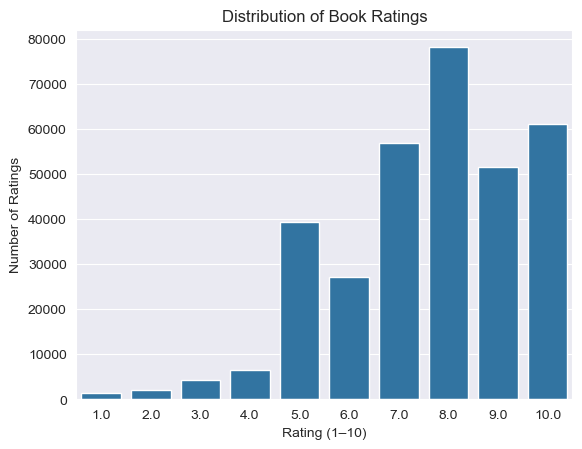

In [9]:
rating_value_counts = ratings_df["Book-Rating"].value_counts().sort_index()  # Count ratings per value
sns.barplot(x=rating_value_counts.index, y=rating_value_counts.values)  # Create bar plot
plt.title("Distribution of Book Ratings")  # Set title
plt.xlabel("Rating (1–10)")  # Set x-axis label
plt.ylabel("Number of Ratings")  # Set y-axis label
plt.show()  # Display plot


## EDA: Long Tail Distribution - Ratings per Book
# to Analyze popularity distribution of books (how many books have few/many ratings)
# Insight: Shows the "long tail" phenomenon where few books get most ratings


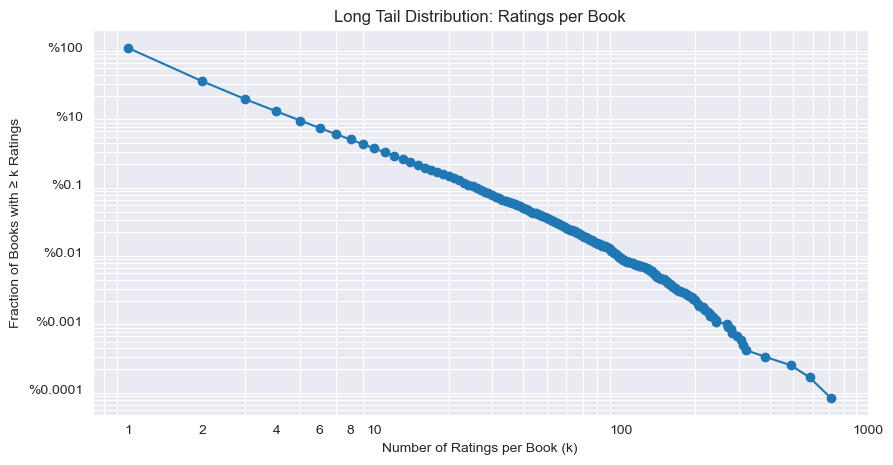

In [10]:
ratings_per_book = ratings_df["ISBN"].value_counts().rename("ratings_per_book")  # Count ratings per book
k_values = np.unique(ratings_per_book.values[::-1])  # Get unique rating counts
fraction_ge_k = [
    len(ratings_per_book[ratings_per_book >= k]) / len(ratings_per_book) for k in k_values
]  # Calculate fraction of books with ≥k ratings

plt.figure(figsize=(10, 5))  # Set figure size
plt.loglog(k_values, fraction_ge_k, marker="o", linestyle="-")  # Create log-log plot
plt.title("Long Tail Distribution: Ratings per Book")  # Set title
plt.xlabel("Number of Ratings per Book (k)")  # Set x-axis label
plt.ylabel("Fraction of Books with ≥ k Ratings")  # Set y-axis label
plt.grid(which="both")  # Add grid lines

plt.xticks([ 1 , 2 , 4 , 6 , 8 , 10 , 100 , 1000],
['1','2','4','6','8','10','100','1000'])  # Set x-ticks

plt.yticks([ 1e-5 , 1e-4 , 1e-3 , 1e-2 ,1e-1 , 1],
['%0.0001','%0.001','%0.01','%0.1','%10','%100']) # Set y-ticks

plt.show()  # Display plot


## EDA: Long Tail Distribution - Ratings per User
# to Analyze user engagement distribution (how many users rate few/many books)
# Insight: Shows if most users rate few books while few power users rate many


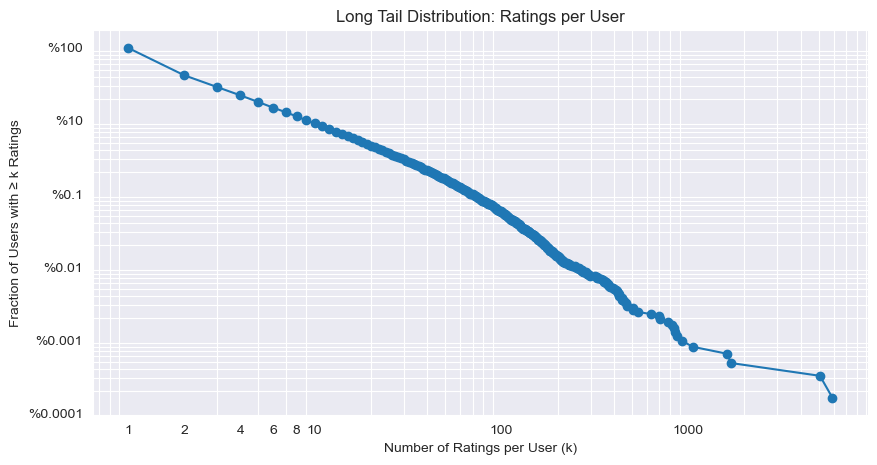

In [11]:
ratings_per_user = ratings_df["User-ID"].value_counts().rename("ratings_per_user")  # Count ratings per user
k_values_user = np.unique(ratings_per_user.values[::-1])  # Get unique rating counts
fraction_ge_k_user = [
    len(ratings_per_user[ratings_per_user >= k]) / len(ratings_per_user) for k in k_values_user
]  # Calculate fraction of users with ≥k ratings

plt.figure(figsize=(10, 5))  # Set figure size
plt.loglog(k_values_user, fraction_ge_k_user, marker="o", linestyle="-")  # Create log-log plot
plt.title("Long Tail Distribution: Ratings per User")  # Set title
plt.xlabel("Number of Ratings per User (k)")  # Set x-axis label
plt.ylabel("Fraction of Users with ≥ k Ratings")  # Set y-axis label

plt.xticks([ 1 , 2 , 4 , 6 , 8 , 10 , 100 , 1000],
['1','2','4','6','8','10','100','1000'])  # Set x-ticks

plt.yticks([ 1e-5 , 1e-4 , 1e-3 , 1e-2 ,1e-1 , 1],
['%0.0001','%0.001','%0.01','%0.1','%10','%100']) # Set y-ticks

plt.grid(which="both")  # Add grid lines
plt.show()  # Display plot


## EDA: Ratings per Book - Count vs. Avg
# Examine relationship between number of ratings and average rating
# Insight: Helps identify if popular books (many ratings) tend to have higher/lower ratings


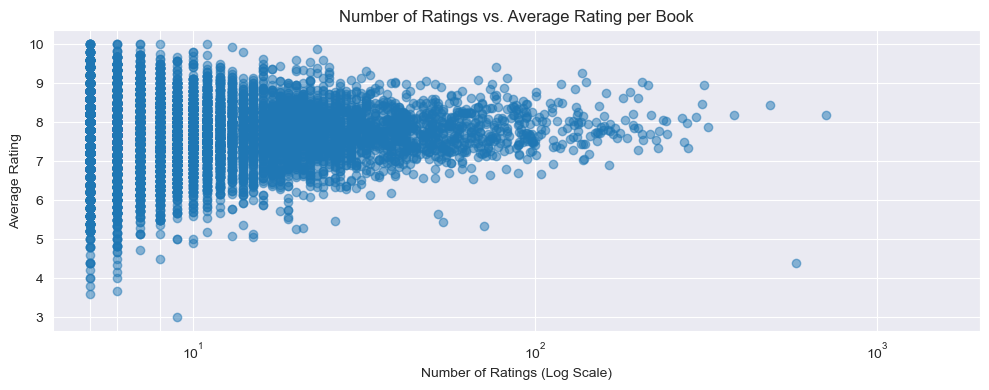

In [12]:
book_rating_stats = (
    ratings_df.groupby("ISBN")["Book-Rating"]
    .agg(mean="mean", size="size")
    .rename(columns={"mean": "avg_rating", "size": "num_ratings"})
)  # Calculate mean and count of ratings per book
book_rating_stats = book_rating_stats[book_rating_stats["num_ratings"] >= 5]  # Filter books with ≥5 ratings

plt.figure(figsize=(10, 4))  # Set figure size
plt.scatter(book_rating_stats["num_ratings"],
            book_rating_stats["avg_rating"], alpha=0.5)  # Create scatter plot
plt.xscale("log")  # Set x-axis to log scale
plt.xticks([5, 6, 8, 10, 100, 1000, 2000])  # Set x-ticks
plt.title("Number of Ratings vs. Average Rating per Book")  # Set title
plt.xlabel("Number of Ratings (Log Scale)")  # Set x-axis label
plt.ylabel("Average Rating")  # Set y-axis label
plt.tight_layout()  # Adjust layout
plt.show()  # Display plot


## EDA: User Avg Rating Distribution
# to Analyze how users distribute their ratings on average
# Insight: Shows if users tend to be generous/strict in their ratings overall


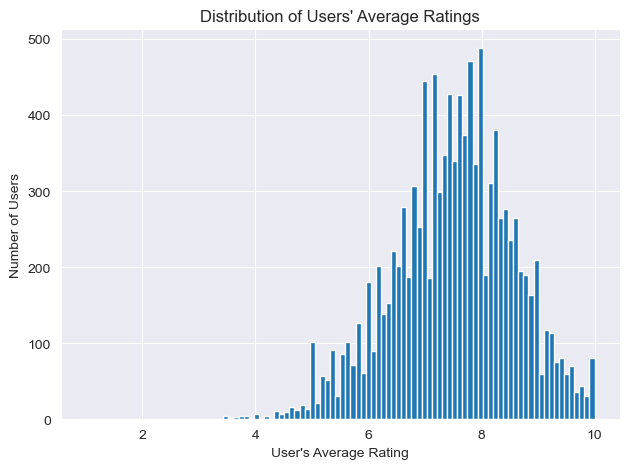

In [13]:
user_avg_ratings = (
    ratings_df.groupby("User-ID")["Book-Rating"]
    .mean()
    .rename("avg_rating")
)  # Calculate mean rating per user
user_avg_ratings = user_avg_ratings[ratings_df["User-ID"].value_counts() >= 5]  # Filter users with ≥5 ratings

plt.hist(user_avg_ratings, bins=100)  # Create histogram
plt.title("Distribution of Users' Average Ratings")  # Set title
plt.xlabel("User's Average Rating")  # Set x-axis label
plt.ylabel("Number of Users")  # Set y-axis label
plt.tight_layout()  # Adjust layout
plt.show()  # Display plot


## Iterative Filtering – K-Core (Users & Books)
# Purpose: Remove sparse users and items to create a denser dataset
# Insight: Helps improve recommendation quality by focusing on meaningful interactions


In [14]:
ratings_df = apply_k_core_filtering(ratings_df)

## Post-Filtering Stats
# Checking statistics after k-core filtering to understand remaining data


In [15]:
print(ratings_df["User-ID"].value_counts().tail())  # Show least active remaining users
print(ratings_df["ISBN"].value_counts().tail())  # Show least popular remaining books


120696    6
120548    6
120178    6
238541    6
276688    6
Name: User-ID, dtype: int64
0385333064    8
0786883219    8
0553575422    8
0452282268    8
0316107255    8
Name: ISBN, dtype: int64


## Check for Duplicated (User, Book) Pairs
# Verifying there are no duplicate user-book rating pairs (data integrity check)


In [16]:
if True in ratings_df.duplicated(subset=["User-ID", "ISBN"]):
    print("duplicated ratings:")
    print(ratings_df[ratings_df.duplicated(subset=["User-ID", "ISBN"])]["User-ID"].value_counts())
else:
    print("no duplicated ratings")


no duplicated ratings


## Final Alignment of Users & Books
# Ensuring all remaining users and books have ratings (data consistency)


In [17]:
books_df,users_df = align_user_book_datasets(ratings_df,books_df,users_df)

## Final Entity Sizes
# Checking final counts of books and users to understand dataset scale


In [18]:
print(len(books_df))  # Count of remaining books
print(len(ratings_df["ISBN"].unique()))  # Count of books with ratings
print(len(users_df))  # Count of remaining users
print(len(ratings_df["User-ID"].unique()))  # Count of users with ratings


3040
3040
3422
3422


## Build User-Item Matrix (CSR)
# Purpose: Create a sparse matrix representation for efficient recommendation algorithms
# Insight: This is the fundamental data structure for collaborative filtering


In [19]:
user_item_csr,user_id_map,isbn_map = build_user_item_matrix(ratings_df)

## Preview of User-Item Matrix
# Purpose: Visualize a small portion of the user-item interaction matrix
# Insight: Helps understand the sparsity and distribution of ratings


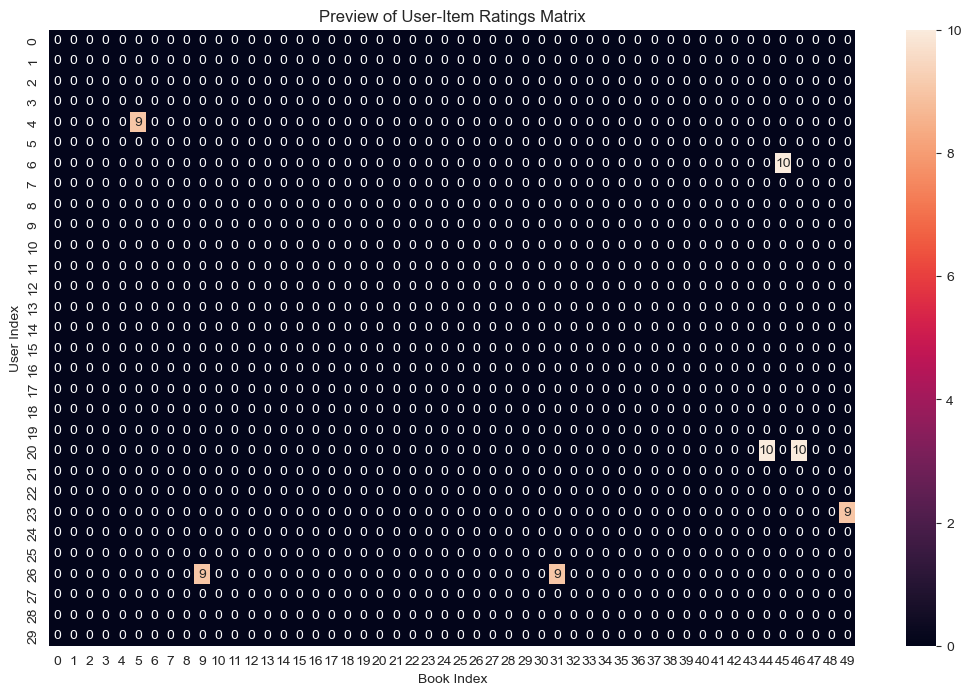

In [20]:
plt.figure(figsize=(13, 8))  # Set figure size
dense_preview = user_item_csr[:30, :50].toarray()  # Extract small dense subset
sns.heatmap(dense_preview, annot=True)  # Create heatmap with values
plt.title("Preview of User-Item Ratings Matrix")  # Set title
plt.xlabel("Book Index")  # Set x-axis label
plt.ylabel("User Index")  # Set y-axis label
plt.show()  # Display plot


## Final Cleaned Ratings
# Displaying the final cleaned ratings dataframe for inspection


In [21]:
ratings_df  # Display the final ratings dataframe

,User-ID,ISBN,Book-Rating
911,277157,0312979517,5.0
917,277157,0345452550,7.0
928,277157,0399146504,7.0
941,277157,0399151451,7.0
945,277157,0425183181,5.0
...,...,...,...
1149711,276688,0553566040,6.0
1149715,276688,0553575104,6.0
1149738,276688,0688156134,8.0
1149743,276688,0836218655,10.0


# Save Processed Data to Files

In [22]:
ratings_df.to_csv(r"../data/processed/ratings_cleaned.csv")
books_df.to_csv(r"../data/processed/books_cleaned.csv")
users_df.to_csv(r"../data/processed/users_cleaned.csv")
save_npz(r"../data/processed/user_item.npz", user_item_csr)

In [23]:
user_id_map = {str(k): int(v) for k, v in user_id_map.items()}
isbn_map = {str(k): int(v) for k, v in isbn_map.items()}

with open("../data/processed/mappers.json", "w") as f:
    json.dump(user_id_map, f, indent=4) 
    json.dump(isbn_map, f, indent=4)